# Part-of-Speech Tagging using Feedforward Networks

Author: Pierre Nugues

A part-of-speech tagger using feed-forward networks and trained on a corpus following the Universal Dependencies format. Here we use the English Web Treebank:
https://github.com/UniversalDependencies/UD_English-EWT/tree/master.

## Python Headers

### The Modules

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import math

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### Some Parameters

In [2]:
SCALER = False
SIMPLE_MODEL = False
BATCH_SIZE = 64
EPOCHS = 4
MINI_CORPUS = False

In [3]:
random.seed(1234)
torch.manual_seed(1234)

## Preprocessing

### Loading the Corpus

In [4]:
def load_ud_en_ewt():
    BASE_DIR = '/Users/pierre/Documents/Cours/EDAN20/corpus/ud-treebanks-v2.9/UD_English-EWT/'
    train_file = BASE_DIR + 'en_ewt-ud-train.conllu'
    dev_file = BASE_DIR + 'en_ewt-ud-dev.conllu'
    test_file = BASE_DIR + 'en_ewt-ud-test.conllu'
    column_names = ['ID', 'FORM', 'LEMMA', 'UPOS', 'XPOS', 
                    'FEATS', 'HEAD', 'DEPREL', 'HEAD', 'DEPS', 'MISC']
    column_names = list(map(str.lower, column_names))
    train_sentences = open(train_file).read().strip()
    dev_sentences = open(dev_file).read().strip()
    test_sentences = open(test_file).read().strip()
    # test2_sentences = open(test2_file).read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names

def load_conll2009_pos():
    BASE_DIR = '/Users/pierre/Documents/Cours/EDAN20/corpus/conll2009/en/'
    train_file = BASE_DIR + 'CoNLL2009-ST-English-train-pos.txt'
    dev_file = BASE_DIR + 'CoNLL2009-ST-English-development-pos.txt'
    test_file = BASE_DIR + 'CoNLL2009-ST-test-words-pos.txt'
    # test2_file = 'simple_pos_test.txt'

    column_names = ['id', 'form', 'lemma', 'plemma', 'pos', 'ppos']

    train_sentences = open(train_file).read().strip()
    dev_sentences = open(dev_file).read().strip()
    test_sentences = open(test_file).read().strip()
    # test2_sentences = open(test2_file).read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names

# train_sentences, dev_sentences, test_sentences, column_names = \
# load_conll2009_pos()
train_sentences, dev_sentences, test_sentences, column_names =\
load_ud_en_ewt()
train_sentences[:350]

'# newdoc id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000\n# sent_id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-0001\n# newpar id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-p0001\n# text = Al-Zaman : American forces killed Shaikh Abdullah al-Ani, the preacher at the mosque in the town o'

### Converting the Corpus in a Dictionary
We follow the fit-transform pattern of sklearn

In [5]:
import regex as re

class Token(dict):
    pass

class CoNLLDictorizer:

    def __init__(self, column_names, sent_sep='\n\n', col_sep=' +'):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus):
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence):
        rows = re.split('\n', sentence)
        rows = [row for row in rows if row[0] != '#']
        return [Token(dict(zip(self.column_names,
                               re.split(self.col_sep, row))))
                for row in rows]

In [6]:
conll_dict = CoNLLDictorizer(column_names, col_sep='\t')

train_dict = conll_dict.transform(train_sentences)
dev_dict = conll_dict.transform(dev_sentences)
test_dict = conll_dict.transform(test_sentences)

if MINI_CORPUS:
    train_dict = train_dict[:len(train_dict) // 5]
print('First sentence, train:', train_dict[0])

First sentence, train: [{'id': '1', 'form': 'Al', 'lemma': 'Al', 'upos': 'PROPN', 'xpos': 'NNP', 'feats': 'Number=Sing', 'head': '0:root', 'deprel': 'root', 'deps': 'SpaceAfter=No'}, {'id': '2', 'form': '-', 'lemma': '-', 'upos': 'PUNCT', 'xpos': 'HYPH', 'feats': '_', 'head': '1:punct', 'deprel': 'punct', 'deps': 'SpaceAfter=No'}, {'id': '3', 'form': 'Zaman', 'lemma': 'Zaman', 'upos': 'PROPN', 'xpos': 'NNP', 'feats': 'Number=Sing', 'head': '1:flat', 'deprel': 'flat', 'deps': '_'}, {'id': '4', 'form': ':', 'lemma': ':', 'upos': 'PUNCT', 'xpos': ':', 'feats': '_', 'head': '1:punct', 'deprel': 'punct', 'deps': '_'}, {'id': '5', 'form': 'American', 'lemma': 'American', 'upos': 'ADJ', 'xpos': 'JJ', 'feats': 'Degree=Pos', 'head': '6:amod', 'deprel': 'amod', 'deps': '_'}, {'id': '6', 'form': 'forces', 'lemma': 'force', 'upos': 'NOUN', 'xpos': 'NNS', 'feats': 'Number=Plur', 'head': '7:nsubj', 'deprel': 'nsubj', 'deps': '_'}, {'id': '7', 'form': 'killed', 'lemma': 'kill', 'upos': 'VERB', 'xpos'

### Extracting the Context and Dictorizing it
We extract windows of five words surrounding the word

In [7]:
class ContextDictorizer():
    """
    Extract contexts of words in a sequence
    Contexts are of w_size to the left and to the right
    Builds an X matrix in the form of a dictionary
    and possibly extracts the output, y, if not in the test step
    If the test_step is True, returns y = []
    """

    def __init__(self, input='form', output='upos', w_size=2, tolower=True):
        self.BOS_symbol = '__BOS__'
        self.EOS_symbol = '__EOS__'
        self.input = input
        self.output = output
        self.w_size = w_size
        self.tolower = tolower
        # This was not correct as the names were not sorted
        # self.feature_names = [input + '_' + str(i)
        #                     for i in range(-w_size, w_size + 1)]
        # To be sure the names are ordered
        zeros = math.ceil(math.log10(2 * w_size + 1))
        self.feature_names = [input + '_' + str(i).zfill(zeros) for 
                              i in range(2 * w_size + 1)]

    def fit(self, sentences):
        """
        Build the padding rows
        :param sentences:
        :return:
        """
        self.column_names = sentences[0][0].keys()
        start = [self.BOS_symbol] * len(self.column_names)
        end = [self.EOS_symbol] * len(self.column_names)
        start_token = Token(dict(zip(self.column_names, start)))
        end_token = Token(dict(zip(self.column_names, end)))
        self.start_rows = [start_token] * self.w_size
        self.end_rows = [end_token] * self.w_size

    def transform(self, sentences, training_step=True):
        X_corpus = []
        y_corpus = []
        for sentence in sentences:
            X, y = self._transform_sentence(sentence, training_step)
            X_corpus += X
            if training_step:
                y_corpus += y
        return X_corpus, y_corpus

    def fit_transform(self, sentences):
        self.fit(sentences)
        return self.transform(sentences)

    def _transform_sentence(self, sentence, training_step=True):
        # We extract y
        if training_step:
            y = [row[self.output] for row in sentence]
        else:
            y = None

        # We pad the sentence
        sentence = self.start_rows + sentence + self.end_rows

        # We extract the features
        X = list()
        for i in range(len(sentence) - 2 * self.w_size):
            # x is a row of X
            x = list()
            # The words in lower case
            for j in range(2 * self.w_size + 1):
                if self.tolower:
                    x.append(sentence[i + j][self.input].lower())
                else:
                    x.append(sentence[i + j][self.input])
            # We represent the feature vector as a dictionary
            X.append(dict(zip(self.feature_names, x)))
        return X, y

    def print_example(self, sentences, id=1968):
        """
        :param corpus:
        :param id:
        :return:
        """
        # We print the features to check they match Table 8.1 in my book (second edition)
        # We use the training step extraction with the dynamic features
        Xs, ys = self._transform_sentence(sentences[id])
        print('X for sentence #', id, Xs)
        print('y for sentence #', id, ys)

### Running the Feature Extraction

In [8]:
context_dictorizer = ContextDictorizer()
context_dictorizer.fit(train_dict)
X_train_dict, y_train_cat = context_dictorizer.transform(train_dict)
X_val_dict, y_val_cat = context_dictorizer.transform(dev_dict)

In [9]:
context_dictorizer.print_example(train_dict)

X for sentence # 1968 [{'form_0': '__bos__', 'form_1': '__bos__', 'form_2': 'do', 'form_3': 'we', 'form_4': 'intend'}, {'form_0': '__bos__', 'form_1': 'do', 'form_2': 'we', 'form_3': 'intend', 'form_4': 'to'}, {'form_0': 'do', 'form_1': 'we', 'form_2': 'intend', 'form_3': 'to', 'form_4': 'reference'}, {'form_0': 'we', 'form_1': 'intend', 'form_2': 'to', 'form_3': 'reference', 'form_4': 'a'}, {'form_0': 'intend', 'form_1': 'to', 'form_2': 'reference', 'form_3': 'a', 'form_4': 'particular'}, {'form_0': 'to', 'form_1': 'reference', 'form_2': 'a', 'form_3': 'particular', 'form_4': 'manufacturer'}, {'form_0': 'reference', 'form_1': 'a', 'form_2': 'particular', 'form_3': 'manufacturer', 'form_4': ','}, {'form_0': 'a', 'form_1': 'particular', 'form_2': 'manufacturer', 'form_3': ',', 'form_4': 'or'}, {'form_0': 'particular', 'form_1': 'manufacturer', 'form_2': ',', 'form_3': 'or', 'form_4': 'should'}, {'form_0': 'manufacturer', 'form_1': ',', 'form_2': 'or', 'form_3': 'should', 'form_4': 'this

### Vectorizing the ${X}$ Matrix

In [10]:
# We transform the X symbols into numbers
dict_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
X_train_num = dict_vectorizer.fit_transform(X_train_dict)
X_val_num = dict_vectorizer.transform(X_val_dict)

In [11]:
if SCALER:
    # We standardize X_train_num
    scaler = StandardScaler(with_mean=False)
    X_train = scaler.fit_transform(X_train_num)
    X_val = scaler.transform(X_val_num)
else:
    X_train = X_train_num
    X_val = X_val_num
print(X_train.shape)
#X[0, :100].toarray()

(207229, 81634)


### Vectorizing $\mathbf{y}$

The POS and the number of different POS

In [12]:
pos_list = sorted(set(y_train_cat))
NB_CLASSES = len(pos_list) + 1
pos_list

['ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'PUNCT',
 'SCONJ',
 'SYM',
 'VERB',
 'X',
 '_']

We build a part-of-speech index. We keep 0 for unknown symbols in the test set

In [13]:
idx2pos = dict(enumerate(pos_list, start=1))
pos2idx = {v: k for k, v in idx2pos.items()}
print(idx2pos)
pos2idx

{1: 'ADJ', 2: 'ADP', 3: 'ADV', 4: 'AUX', 5: 'CCONJ', 6: 'DET', 7: 'INTJ', 8: 'NOUN', 9: 'NUM', 10: 'PART', 11: 'PRON', 12: 'PROPN', 13: 'PUNCT', 14: 'SCONJ', 15: 'SYM', 16: 'VERB', 17: 'X', 18: '_'}


{'ADJ': 1,
 'ADP': 2,
 'ADV': 3,
 'AUX': 4,
 'CCONJ': 5,
 'DET': 6,
 'INTJ': 7,
 'NOUN': 8,
 'NUM': 9,
 'PART': 10,
 'PRON': 11,
 'PROPN': 12,
 'PUNCT': 13,
 'SCONJ': 14,
 'SYM': 15,
 'VERB': 16,
 'X': 17,
 '_': 18}

We encode $\mathbf{y}$. We use one symbol for unknown parts of speech in the test set

In [14]:
y_train = torch.LongTensor([pos2idx[i] for i in y_train_cat])
y_val = torch.LongTensor([pos2idx[i] for i in y_val_cat])

In [15]:
y_train_cat[:10]

['PROPN',
 'PUNCT',
 'PROPN',
 'PUNCT',
 'ADJ',
 'NOUN',
 'VERB',
 'PROPN',
 'PROPN',
 'PROPN']

In [16]:
y_train[:10]

tensor([12, 13, 12, 13,  1,  8, 16, 12, 12, 12])

## The Tagger
Our models

In [17]:
X_train = torch.from_numpy(X_train)
X_val = torch.from_numpy(X_val)

In [18]:
X_train.size()[1]

81634

In [19]:
if SIMPLE_MODEL:
    model = nn.Sequential(nn.Linear(X_train.size()[1],
                                    NB_CLASSES))
else:
    model = nn.Sequential(
        nn.Linear(X_train.size()[1],
                  NB_CLASSES * 2),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(NB_CLASSES * 2, NB_CLASSES))


In [20]:
loss_fn = nn.CrossEntropyLoss()    # cross entropy loss
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

In [21]:
model(X_train[:1])

tensor([[ 0.0918,  0.0262,  0.0327,  0.0066,  0.1519, -0.1041, -0.0182,  0.0541,
         -0.1199, -0.0853, -0.0073,  0.1306, -0.0581, -0.0267, -0.0634,  0.0894,
          0.0815,  0.0530, -0.0601]], grad_fn=<AddmmBackward0>)

In [22]:
def batch_inference(model, X, batchsize=2048):
    with torch.no_grad():
        partial = []
        for i in range(0, X.shape[0], batchsize):
            partial.append(model(X[i:i+batchsize]))
    
    return torch.vstack(partial)

In [23]:
y_train_pred = batch_inference(model, X_train)
y_train_pred[:10]

tensor([[ 0.0897,  0.0249,  0.0325,  0.0055,  0.1518, -0.1040, -0.0166,  0.0543,
         -0.1199, -0.0847, -0.0069,  0.1304, -0.0588, -0.0271, -0.0631,  0.0905,
          0.0819,  0.0522, -0.0601],
        [ 0.0924,  0.0259,  0.0320,  0.0022,  0.1504, -0.1060, -0.0187,  0.0521,
         -0.1210, -0.0843, -0.0045,  0.1327, -0.0554, -0.0270, -0.0649,  0.0891,
          0.0869,  0.0550, -0.0594],
        [ 0.0901,  0.0272,  0.0334,  0.0048,  0.1515, -0.1065, -0.0147,  0.0538,
         -0.1195, -0.0859, -0.0036,  0.1302, -0.0573, -0.0306, -0.0633,  0.0890,
          0.0822,  0.0558, -0.0571],
        [ 0.0882,  0.0292,  0.0330,  0.0049,  0.1552, -0.1047, -0.0149,  0.0585,
         -0.1215, -0.0860, -0.0080,  0.1302, -0.0580, -0.0308, -0.0652,  0.0925,
          0.0826,  0.0549, -0.0598],
        [ 0.0922,  0.0226,  0.0311,  0.0042,  0.1507, -0.1059, -0.0154,  0.0543,
         -0.1204, -0.0865, -0.0029,  0.1304, -0.0571, -0.0283, -0.0664,  0.0883,
          0.0833,  0.0572, -0.0566],
     

In [24]:
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [25]:
history = {}
history['accuracy'] = []
history['loss'] = []
history['val_accuracy'] = []
history['val_loss'] = []

In [26]:
for epoch in range(EPOCHS):
    train_loss = 0
    train_accuracy = 0
    val_loss = 0
    val_accuracy = 0
    word_cnt = 0
    batch_cnt = 0
    model.train()
    for X_batch, y_batch in tqdm(dataloader):
        batch_cnt += 1
        y_batch_pred = model(X_batch)
        loss = loss_fn(y_batch_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    model.eval()
    with torch.no_grad():
        Y_train_pred = batch_inference(model, X_train)
        history['accuracy'] += [sum(torch.argmax(Y_train_pred, dim=-1) == y_train)/y_train.size()[0]]
        history['loss'] += [train_loss/batch_cnt]

        Y_val_pred = model(X_val)
        val_loss = loss_fn(Y_val_pred, y_val)
        history['val_loss'] += [val_loss.item()]
        history['val_accuracy'] += [sum(torch.argmax(Y_val_pred, dim=-1) == y_val)/y_val.size()[0]]
    

100%|██████████| 6476/6476 [04:07<00:00, 26.13it/s]


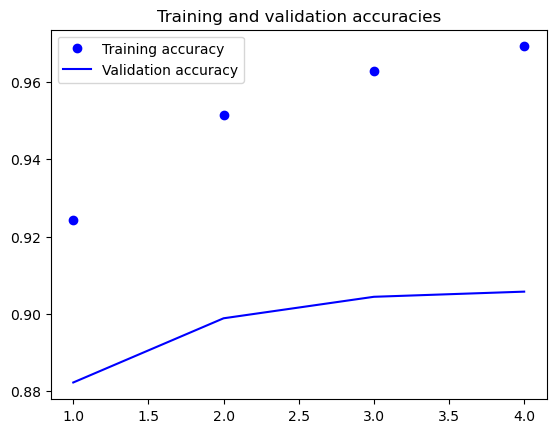

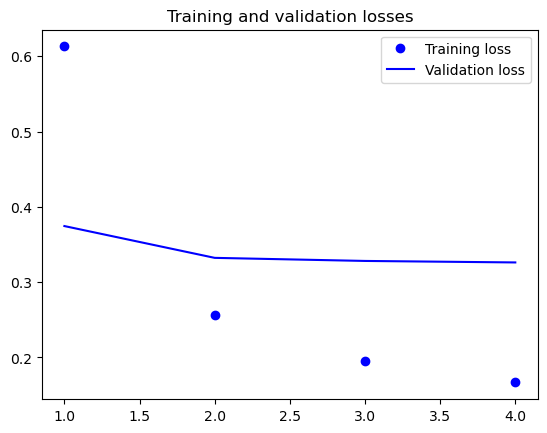

In [27]:
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracies')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()

plt.show()

### Formatting the Test Set

In [28]:
X_test_dict, y_test_cat = context_dictorizer.transform(test_dict)

#### $\mathbf{y}$

In [29]:
y_test_cat[:5]

['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP']

In [30]:
y_test = torch.LongTensor([pos2idx.get(i, 0) for i in y_test_cat])

In [31]:
y_test[:5]

tensor([11, 14, 12, 16,  2])

#### $\mathbf{X}$

In [32]:
# We transform the symbols into numbers
X_test_num = dict_vectorizer.transform(X_test_dict)
if SCALER:
    # We standardize X_num
    X_test = scaler.transform(X_test_num)
else:
    X_test = X_test_num

In [33]:
X_test = torch.from_numpy(X_test)

In [34]:
X_test.size()

torch.Size([25456, 81634])

### Predicting a Value

In [35]:
Y_test_pred = model(X_test)
Y_test_pred

tensor([[ -45.8427,   -8.3240,  -12.3348,  ...,   -5.9812,  -10.9843,
          -10.2438],
        [ -65.7320,  -13.2302,  -11.8311,  ...,  -11.8523,  -19.9016,
          -16.3629],
        [ -32.2234,   -3.4304,  -12.3107,  ...,   -0.6936,   -4.6112,
           -7.1819],
        ...,
        [ -42.6081,   -6.5319,    2.2036,  ...,   -8.6362,  -11.9412,
          -29.2858],
        [ -40.1380,   -4.1916,  -13.7418,  ...,    4.1039,   -8.3322,
          -12.2659],
        [-111.4167,  -21.8773,  -26.2412,  ...,  -12.5351,   -0.8452,
          -46.4268]], grad_fn=<AddmmBackward0>)

In [36]:
torch.argmax(model(X_test), dim=-1)

tensor([11, 14, 12,  ..., 10, 16, 13])

In [37]:
list(map(lambda x: idx2pos[x], torch.argmax(model(X_test), dim=-1).tolist()))

['PRON',
 'SCONJ',
 'PROPN',
 'VERB',
 'ADP',
 'NOUN',
 'PUNCT',
 'PRON',
 'SCONJ',
 'PROPN',
 'VERB',
 'ADP',
 'PRON',
 'NOUN',
 'PUNCT',
 'NOUN',
 'PUNCT',
 'CCONJ',
 'ADV',
 'NOUN',
 'PUNCT',
 'VERB',
 'ADP',
 'DET',
 'ADJ',
 'PUNCT',
 'NOUN',
 'NOUN',
 'NOUN',
 'PUNCT',
 'PUNCT',
 'ADP',
 'PROPN',
 'VERB',
 'ADP',
 'PROPN',
 'PROPN',
 'PROPN',
 'PUNCT',
 'PUNCT',
 'CCONJ',
 'PUNCT',
 'ADP',
 'DET',
 'NOUN',
 'PUNCT',
 'AUX',
 'PRON',
 'ADJ',
 'ADV',
 'DET',
 'ADJ',
 'NOUN',
 'ADP',
 'DET',
 'NOUN',
 'SCONJ',
 'PRON',
 'AUX',
 'DET',
 'ADJ',
 'NOUN',
 'PUNCT',
 'PUNCT',
 'DET',
 'NOUN',
 'NOUN',
 'NOUN',
 'PRON',
 '_',
 'PROPN',
 'PART',
 'VERB',
 'ADP',
 'NOUN',
 'AUX',
 'VERB',
 'PUNCT',
 'PRON',
 '_',
 'PRON',
 'AUX',
 'ADV',
 'VERB',
 'ADV',
 'PUNCT',
 'CCONJ',
 '_',
 'PRON',
 'AUX',
 'ADV',
 'ADV',
 'PUNCT',
 'VERB',
 'ADP',
 'DET',
 'NOUN',
 'PUNCT',
 'PROPN',
 'AUX',
 'DET',
 'ADJ',
 'NOUN',
 'NOUN',
 'PUNCT',
 'AUX',
 'PRON',
 'VERB',
 'PRON',
 'ADP',
 'PRON',
 'ADJ',
 'PUNC

### Testing the Model

In [38]:
sum(torch.argmax(Y_test_pred, dim=-1) == y_test)/y_test.size()[0]

tensor(0.9092)

About 89.59 for the simple model and 90.31 for the second one

## Prediction of parts of speech

In [39]:
def predict_sentence(sentence, dict_vect, model, idx2pos):
    column_names = ['id', 'form']
    sentence = list(enumerate(sentence.lower().split(), start=1))
    conll_cols = ''
    for tuple in sentence:
        conll_cols += str(tuple[0]) + '\t' + tuple[1] + '\n'
    # print(conll_cols)

    conll_dict = CoNLLDictorizer(column_names, col_sep='\t')
    sent_dict = conll_dict.transform(conll_cols)
    # print('Sentence:', sent_dict[0])

    context_dictorizer = ContextDictorizer()
    context_dictorizer.fit(sent_dict)
    X_dict, y = context_dictorizer.transform(sent_dict, 
                                             training_step=False)
    # print('Sentence, padded:', X_dict)
    # print('POS, y:', y)
    
    X_num = dict_vect.transform(X_dict)
    if SCALER:
    # We standardize X_num
        X = scaler.transform(X_num)
    else:
        X = X_num

    X = torch.from_numpy(X)
    # print(X)
    y_prob = model(X)
    y_pred = y_prob.argmax(dim=-1)
    y_pred_cat = [idx2pos[i.item()] for i in y_pred]
    return y_pred_cat

In [40]:
sentences = ["That round table might collapse .",
                 "The man can learn well .",
                 "The man can swim .",
                 "The man can simwo ."]
for sentence in sentences:
    y_test_pred_cat = predict_sentence(sentence.lower(), 
                                       dict_vectorizer,
                                       model,
                                       idx2pos)
    print(sentence)
    print(y_test_pred_cat)

That round table might collapse .
['PRON', 'ADV', 'NOUN', 'AUX', 'VERB', 'PUNCT']
The man can learn well .
['DET', 'NOUN', 'AUX', 'VERB', 'INTJ', 'PUNCT']
The man can swim .
['DET', 'NOUN', 'AUX', 'VERB', 'PUNCT']
The man can simwo .
['DET', 'NOUN', 'AUX', 'VERB', 'PUNCT']
